In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [63]:
GFDL = xr.open_mfdataset('data/NMME/GFDL-SPEAR/prec/prec.GFDL-SPEAR.2024.mon_Apr.nc')
GFDL = GFDL.assign_coords(X=(((GFDL.X + 180) % 360) - 180)).sortby(['X'])

CanESM5 = xr.open_mfdataset('data/NMME/CanESM5/prec/prec.CanESM5.2020.mon_Apr.nc')
CanESM5 = CanESM5.assign_coords(X=(((CanESM5.X + 180) % 360) - 180)).sortby(['X'])

CCSM4 = xr.open_mfdataset('data/NMME/COLA-RSMAS-CCSM4/prec/prec.COLA-RSMAS-CCSM4.2024.mon_Apr.nc')
CCSM4 = CCSM4.assign_coords(X=(((CCSM4.X + 180) % 360) - 180)).sortby(['X'])

CESM1 = xr.open_mfdataset('data/NMME/COLA-RSMAS-CESM1/prec/prec.COLA-RSMAS-CESM1.2023.mon_Apr.nc')
CESM1 = CESM1.assign_coords(X=(((CESM1.X + 180) % 360) - 180)).sortby(['X'])

GEM5 = xr.open_mfdataset('data/NMME/GEM5.2-NEMO/prec/prec.GEM5.2-NEMO.2020.mon_Apr.nc')
GEM5 = GEM5.assign_coords(X=(((GEM5.X + 180) % 360) - 180)).sortby(['X'])

NASA = xr.open_mfdataset('data/NMME/NASA-GEOSS2S/prec/prec.NASA-GEOSS2S.1998.mon_Apr.nc')
NASA = NASA.assign_coords(X=(((NASA.X + 180) % 360) - 180)).sortby(['X'])

NCEP = xr.open_mfdataset('data/NMME/NCEP-CFSv2/prec/prec.NCEP-CFSv2.2024.mon_Apr.nc')
NCEP = NCEP.assign_coords(X=(((NCEP.X + 180) % 360) - 180)).sortby(['X'])

chirps = xr.open_dataset('data/CHIRPS/chirps-v2.0.monthly.nc')

# GFDL 04/2024, Predicted Precip Data, 0.5 lead time

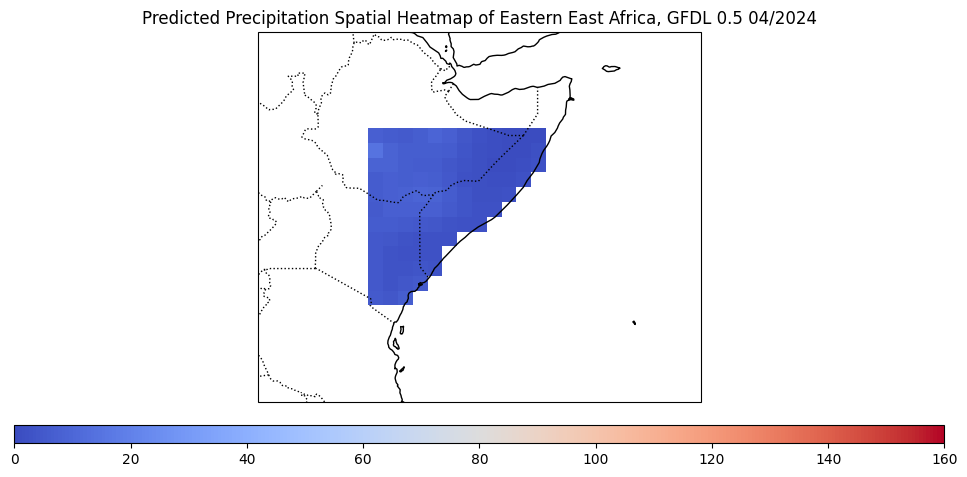

In [134]:
GFDL_Apr2024 = xr.open_mfdataset('data/NMME/GFDL-SPEAR/prec/prec.GFDL-SPEAR.2024.mon_Apr.nc')
GFDL_Apr2024 = GFDL_Apr2024.assign_coords(X=(((GFDL_Apr2024.X + 180) % 360) - 180)).sortby(['X'])

### Subset to Eastern East Africa
GFDL_Apr2024_eastern_east_africa = (GFDL_Apr2024.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of GFDL
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37,
                                                                                  51))  # One degree of resolution must be added for interpolation
                              .interp_like(GFDL_Apr2024_eastern_east_africa, method='nearest'))

GFDL_Apr2024_eastern_east_africa_df = GFDL_Apr2024_eastern_east_africa.to_dataframe().reset_index()
GFDL_Apr2024_eastern_east_africa_df = GFDL_Apr2024_eastern_east_africa_df[GFDL_Apr2024_eastern_east_africa_df['lead time'] == 0.5]

# Calculate realized dates for GFDL, convert to dataframe
GFDL_Apr2024_eastern_east_africa_df['realization_time'] = GFDL_Apr2024_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and GFDL dataframe
GFDL_Apr2024_eastern_east_africa_merged_df = GFDL_Apr2024_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
GFDL_Apr2024_eastern_east_africa_merged_df = GFDL_Apr2024_eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'realization_time'])
GFDL_Apr2024_eastern_east_africa_merged_df.to_csv('data/csv/GFDL_Apr2024_eastern_east_africa_merged.csv')

df = GFDL_Apr2024_eastern_east_africa_merged_df

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='predicted precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
pred = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')


# 5. Plot the heatmap.
# pcolormesh plots the 2D data over the longitude/latitude grid.
heatmap = ax.pcolormesh(lons, lats, pred, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin = 0, vmax = 160)

# 6. Add a title and colorbar.
plt.title('Predicted Precipitation Spatial Heatmap of Eastern East Africa, GFDL 0.5 04/2024')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)

# 7. Display the plot.
plt.show()

# NCEP 04/2024, predicted precip data

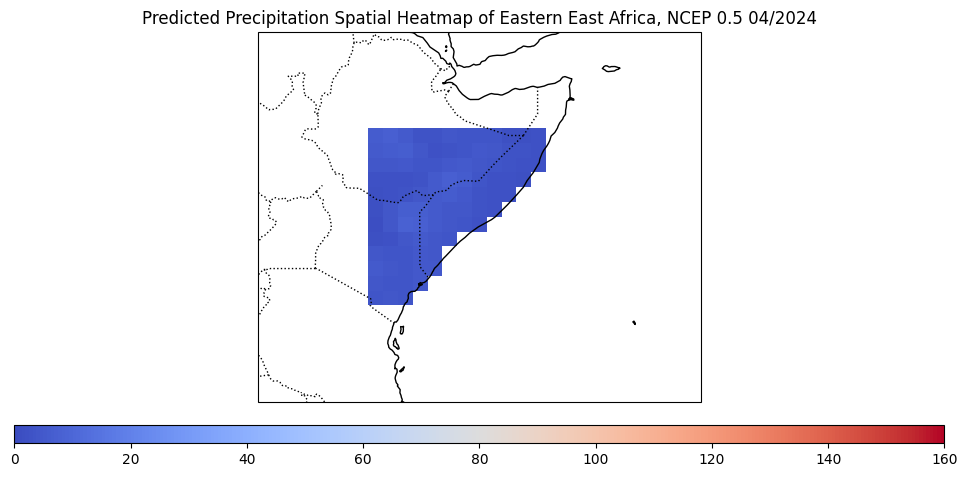

In [135]:
NCEP_Apr2024 = xr.open_mfdataset('data/NMME/NCEP-CFSv2/prec/prec.NCEP-CFSv2.2024.mon_Apr.nc')
NCEP_Apr2024 = NCEP_Apr2024.assign_coords(X=(((NCEP_Apr2024.X + 180) % 360) - 180)).sortby(['X'])

### Subset to Eastern East Africa
NCEP_Apr2024_eastern_east_africa = (NCEP_Apr2024.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of NCEP
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37, 51))  # One degree of resolution must be added for interpolation
                              .interp_like(NCEP_Apr2024_eastern_east_africa, method='nearest'))

NCEP_Apr2024_eastern_east_africa_df = NCEP_Apr2024_eastern_east_africa.to_dataframe().reset_index()
NCEP_Apr2024_eastern_east_africa_df = NCEP_Apr2024_eastern_east_africa_df[NCEP_Apr2024_eastern_east_africa_df['lead time'] == 0.5]

# Calculate realized dates for NCEP, convert to dataframe
NCEP_Apr2024_eastern_east_africa_df['realization_time'] = NCEP_Apr2024_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and NCEP dataframe
NCEP_Apr2024_eastern_east_africa_merged_df = NCEP_Apr2024_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
NCEP_Apr2024_eastern_east_africa_merged_df = NCEP_Apr2024_eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'realization_time'])
NCEP_Apr2024_eastern_east_africa_merged_df.to_csv('data/csv/NCEP_Apr2024_eastern_east_africa_merged.csv')

df = NCEP_Apr2024_eastern_east_africa_merged_df

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='predicted precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
pred = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the heatmap
heatmap = ax.pcolormesh(lons, lats, pred, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=0, vmax=160)

# Add a title and colorbar
plt.title('Predicted Precipitation Spatial Heatmap of Eastern East Africa, NCEP 0.5 04/2024')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Pred_precip_EEA_NCEP_Apr2024.png')
# Display the plot
plt.show()

# CCSM4 04/2024, predicted precip data

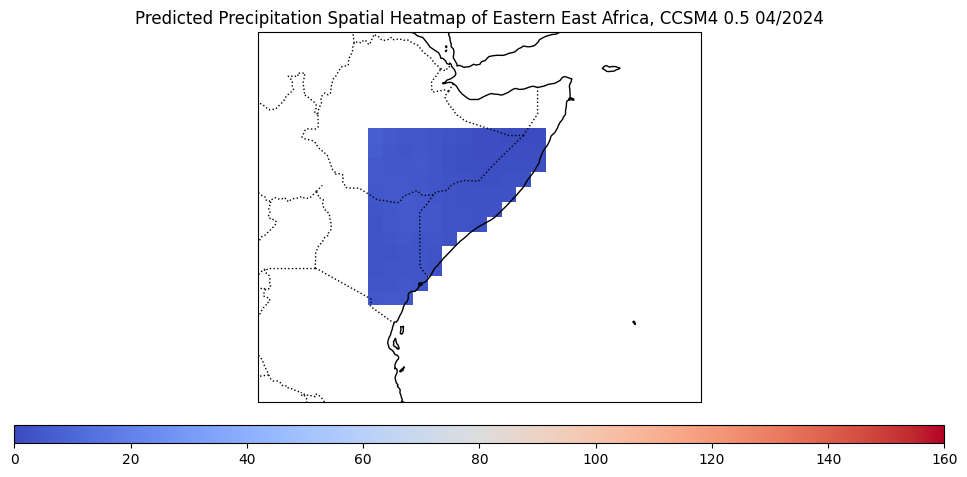

In [136]:
CCSM4_Apr2024 = xr.open_mfdataset('data/NMME/COLA-RSMAS-CCSM4/prec/prec.COLA-RSMAS-CCSM4.2024.mon_Apr.nc')
CCSM4_Apr2024 = CCSM4_Apr2024.assign_coords(X=(((CCSM4_Apr2024.X + 180) % 360) - 180)).sortby(['X'])

### Subset to Eastern East Africa
CCSM4_Apr2024_eastern_east_africa = (CCSM4_Apr2024.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of CCSM4
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37, 51))  # One degree of resolution must be added for interpolation
                              .interp_like(CCSM4_Apr2024_eastern_east_africa, method='nearest'))

CCSM4_Apr2024_eastern_east_africa_df = CCSM4_Apr2024_eastern_east_africa.to_dataframe().reset_index()
CCSM4_Apr2024_eastern_east_africa_df = CCSM4_Apr2024_eastern_east_africa_df[CCSM4_Apr2024_eastern_east_africa_df['lead time'] == 0.5]

# Calculate realized dates for CCSM4, convert to dataframe
CCSM4_Apr2024_eastern_east_africa_df['realization_time'] = CCSM4_Apr2024_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and CCSM4 dataframe
CCSM4_Apr2024_eastern_east_africa_merged_df = CCSM4_Apr2024_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
CCSM4_Apr2024_eastern_east_africa_merged_df = CCSM4_Apr2024_eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'realization_time'])
CCSM4_Apr2024_eastern_east_africa_merged_df.to_csv('data/csv/CCSM4_Apr2024_eastern_east_africa_merged.csv')

df = CCSM4_Apr2024_eastern_east_africa_merged_df

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='predicted precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
pred = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the heatmap
heatmap = ax.pcolormesh(lons, lats, pred, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=0, vmax=160)

# Add a title and colorbar
plt.title('Predicted Precipitation Spatial Heatmap of Eastern East Africa, CCSM4 0.5 04/2024')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Pred_precip_EEA_CCSM4_Apr2024.png')
# Display the plot
plt.show()

# CHIRPS 04/2024, actual precip data

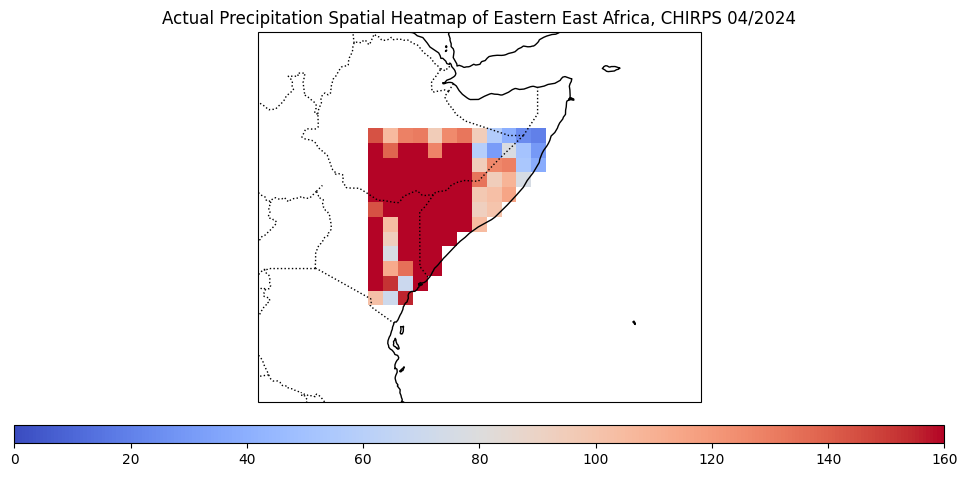

In [137]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
actual = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')


# 5. Plot the heatmap.
# pcolormesh plots the 2D data over the longitude/latitude grid.
heatmap = ax.pcolormesh(lons, lats, actual, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin = 0, vmax = 160)

# 6. Add a title and colorbar.
plt.title('Actual Precipitation Spatial Heatmap of Eastern East Africa, CHIRPS 04/2024')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Actual_precip_EEA_Apr2024.png')
# 7. Display the plot.
plt.show()

# CESM1 04/2021, predicted precip data

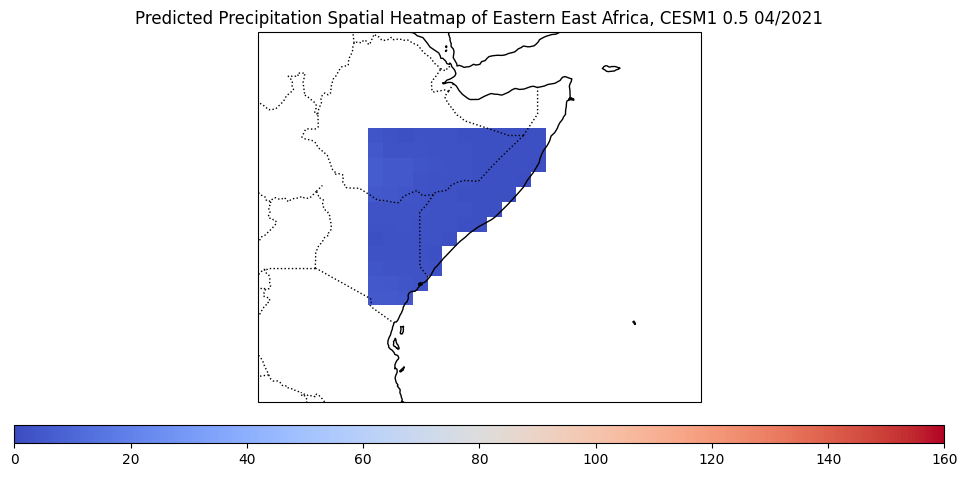

In [138]:
CESM1_Apr2021 = xr.open_mfdataset('data/NMME/COLA-RSMAS-CESM1/prec/prec.COLA-RSMAS-CESM1.2021.mon_Apr.nc')
CESM1_Apr2021 = CESM1_Apr2021.assign_coords(X=(((CESM1_Apr2021.X + 180) % 360) - 180)).sortby(['X'])

### Subset to Eastern East Africa
CESM1_Apr2021_eastern_east_africa = (CESM1_Apr2021.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of CESM1
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37, 51))  # One degree of resolution must be added for interpolation
                              .interp_like(CESM1_Apr2021_eastern_east_africa, method='nearest'))

CESM1_Apr2021_eastern_east_africa_df = CESM1_Apr2021_eastern_east_africa.to_dataframe().reset_index()
CESM1_Apr2021_eastern_east_africa_df = CESM1_Apr2021_eastern_east_africa_df[CESM1_Apr2021_eastern_east_africa_df['lead time'] == 0.5]
CESM1_Apr2021_eastern_east_africa_df.to_csv('data/csv/CESM1_Apr2021_eastern_east_africa.csv')

# Calculate realized dates for CESM1, convert to dataframe
CESM1_Apr2021_eastern_east_africa_df['realization_time'] = CESM1_Apr2021_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and CESM1 dataframe
CESM1_Apr2021_eastern_east_africa_merged_df = CESM1_Apr2021_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
CESM1_Apr2021_eastern_east_africa_merged_df = CESM1_Apr2021_eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'realization_time'])
CESM1_Apr2021_eastern_east_africa_merged_df.to_csv('data/csv/CESM1_Apr2021_eastern_east_africa_merged.csv')

df = CESM1_Apr2021_eastern_east_africa_merged_df

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='predicted precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
pred = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the heatmap
heatmap = ax.pcolormesh(lons, lats, pred, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=0, vmax=160)

# Add a title and colorbar
plt.title('Predicted Precipitation Spatial Heatmap of Eastern East Africa, CESM1 0.5 04/2021')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Pred_precip_EEA_CESM1_Apr2021.png')
# Display the plot
plt.show()

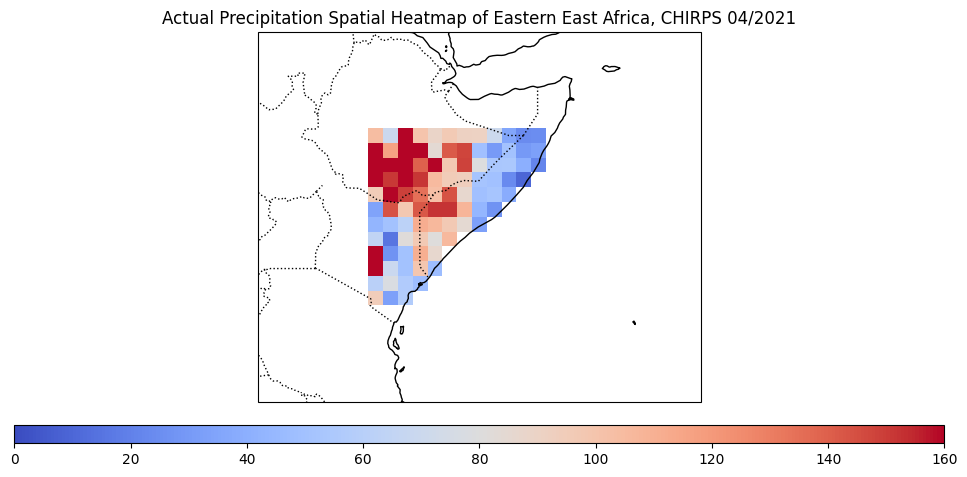

In [140]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
actual = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')


# 5. Plot the heatmap.
# pcolormesh plots the 2D data over the longitude/latitude grid.
heatmap = ax.pcolormesh(lons, lats, actual, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin = 0, vmax = 160)

# 6. Add a title and colorbar.
plt.title('Actual Precipitation Spatial Heatmap of Eastern East Africa, CHIRPS 04/2021')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Actual_precip_EEA_Apr2021.png')
# 7. Display the plot.
plt.show()

# CanESM5 04/2020, predicted precip data

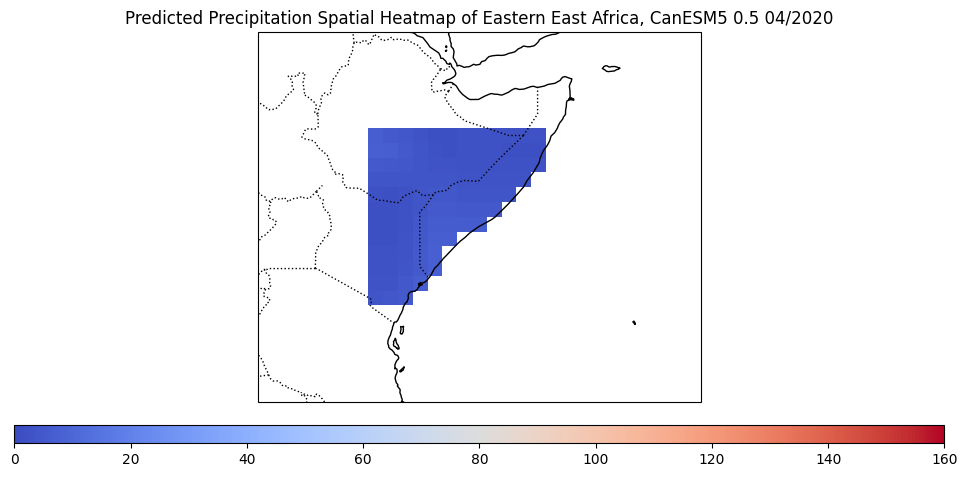

In [141]:
# Load the dataset
CanESM5_Apr2020 = xr.open_mfdataset('data/NMME/CanESM5/prec/prec.CanESM5.2020.mon_Apr.nc')
CanESM5_Apr2020 = CanESM5_Apr2020.assign_coords(X=(((CanESM5_Apr2020.X + 180) % 360) - 180)).sortby(['X'])

### Subset to Eastern East Africa
CanESM5_Apr2020_eastern_east_africa = (CanESM5_Apr2020.sel(Y=slice(-3.5, 8), X=slice(38, 50))
                               .rename(
    {'Y': 'latitude', 'X': 'longitude', 'prec': 'predicted precip', 'S': 'date of prediction', 'L': 'lead time'}))

# Interpolate and subset CHIRPS to match spatial resolution of CanESM5
chirps_eastern_east_africa = (chirps.sel(latitude=slice(-3.5, 9), longitude=slice(37, 51))  # One degree of resolution must be added for interpolation
                              .interp_like(CanESM5_Apr2020_eastern_east_africa, method='nearest'))

CanESM5_Apr2020_eastern_east_africa_df = CanESM5_Apr2020_eastern_east_africa.to_dataframe().reset_index()
CanESM5_Apr2020_eastern_east_africa_df = CanESM5_Apr2020_eastern_east_africa_df[CanESM5_Apr2020_eastern_east_africa_df['lead time'] == 0.5]
CanESM5_Apr2020_eastern_east_africa_df.to_csv('data/csv/CanESM5_Apr2020_eastern_east_africa.csv')

# Calculate realized dates for CanESM5, convert to dataframe
CanESM5_Apr2020_eastern_east_africa_df['realization_time'] = CanESM5_Apr2020_eastern_east_africa_df.apply(
    lambda x: x['date of prediction'] + pd.DateOffset(months=int(x['lead time'])), axis=1)

# Convert CHIRPS to dataframe
chirps_eastern_east_africa_df = chirps_eastern_east_africa.to_dataframe().reset_index()

# Merge CHIRPS and CanESM5 dataframe
CanESM5_Apr2020_eastern_east_africa_merged_df = CanESM5_Apr2020_eastern_east_africa_df.merge(chirps_eastern_east_africa_df, how='left',
                                                                     left_on=['realization_time', 'latitude',
                                                                              'longitude'],
                                                                     right_on=['time', 'latitude',
                                                                               'longitude']).dropna()

# Save to .csv
CanESM5_Apr2020_eastern_east_africa_merged_df = CanESM5_Apr2020_eastern_east_africa_merged_df.drop(
    columns=['date of prediction', 'realization_time'])
CanESM5_Apr2020_eastern_east_africa_merged_df.to_csv('data/csv/CanESM5_Apr2020_eastern_east_africa_merged.csv')

df = CanESM5_Apr2020_eastern_east_africa_merged_df

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='predicted precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
pred = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the heatmap
heatmap = ax.pcolormesh(lons, lats, pred, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin=0, vmax=160)

# Add a title and colorbar
plt.title('Predicted Precipitation Spatial Heatmap of Eastern East Africa, CanESM5 0.5 04/2020')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Pred_precip_EEA_CanESM5_Apr2020.png')
# Display the plot
plt.show()

# acutal chirps data for april 2020

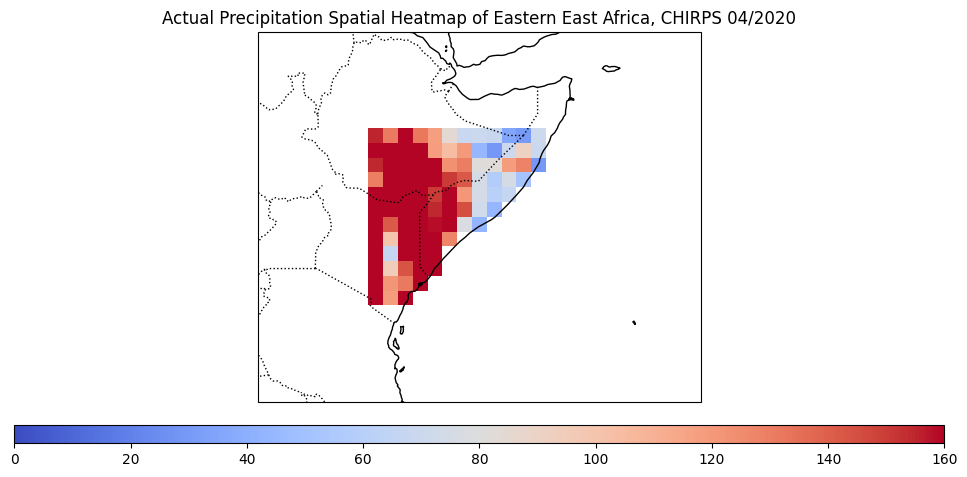

In [142]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()  # Ensure the entire globe is visible
# Pivot the data to create a matrix suitable for pcolormesh
pivot_table = df.pivot_table(index='latitude', columns='longitude', values='precip')
lats = pivot_table.index.values
lons = pivot_table.columns.values
actual = pivot_table.values
# Add features to the map
ax.set_extent([30, 60, -10, 15], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')


# 5. Plot the heatmap.
# pcolormesh plots the 2D data over the longitude/latitude grid.
heatmap = ax.pcolormesh(lons, lats, actual, transform=ccrs.PlateCarree(), cmap='coolwarm', vmin = 0, vmax = 160)

# 6. Add a title and colorbar.
plt.title('Actual Precipitation Spatial Heatmap of Eastern East Africa, CHIRPS 04/2020')
plt.colorbar(heatmap, orientation='horizontal', pad=0.05, aspect=50)
plt.savefig(r'C:\Users\edwin\OneDrive\Documents\GitHub\CHC\figures\Actual_precip_EEA_Apr2020.png')
# 7. Display the plot.
plt.show()